In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install h5py

In [ ]:
import os
from tqdm import tqdm
from google.colab import files

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageEnhance

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D,
    concatenate, BatchNormalization, Activation, LeakyReLU
)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers import Dense, Conv2DTranspose, UpSampling2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, UpSampling2D, Dropout

from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, MeanIoU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1_l2

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

import h5py

In [ ]:
import h5py

# Caminho para o arquivo HDF5 no Google Drive
file_path = '/content/drive/MyDrive/PROJETO/g5_dataset_augmented_processed_28_ago.h5'

# Carregando os arrays do arquivo HDF5
with h5py.File(file_path, 'r') as h5f:
    X_train_processed = h5f['x_train'][:]
    X_test_processed = h5f['x_test'][:]
    y_train_reduced = h5f['y_train'][:]
    y_test_reduced = h5f['y_test'][:]

In [ ]:
X_train_processed.shape, X_test_processed.shape, y_train_reduced.shape, y_test_reduced.shape

((9570, 128, 128, 3),
 (798, 128, 128, 3),
 (9570, 128, 128, 3),
 (798, 128, 128, 3))

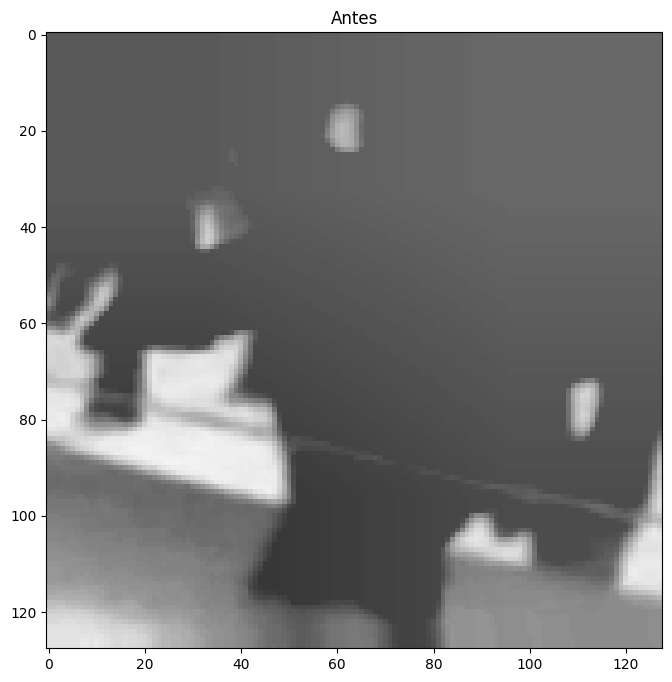

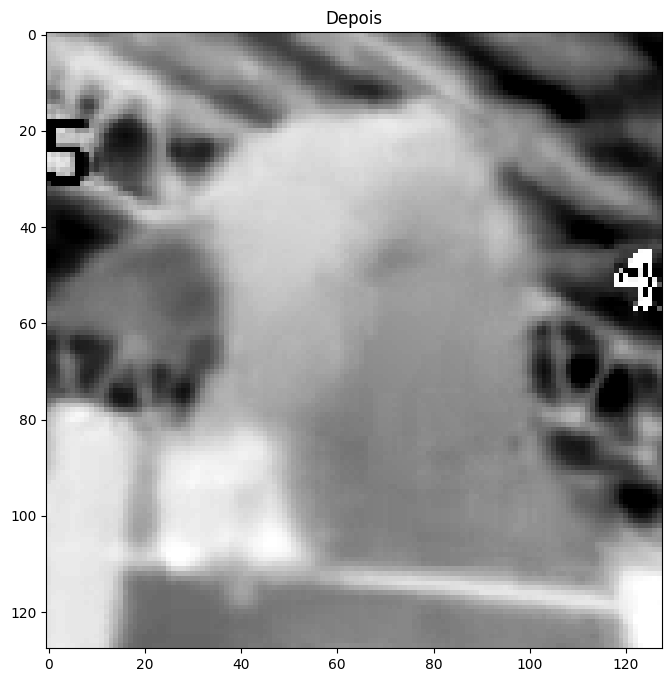

In [ ]:
random_index = np.random.randint(0, X_test_processed.shape[0])

image = X_train_processed[random_index]
image2= X_test_processed[random_index]

plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.title(f'Antes')
plt.show()

plt.figure(figsize=(8, 8))
plt.imshow(image2)
plt.title(f'Depois')
plt.show()

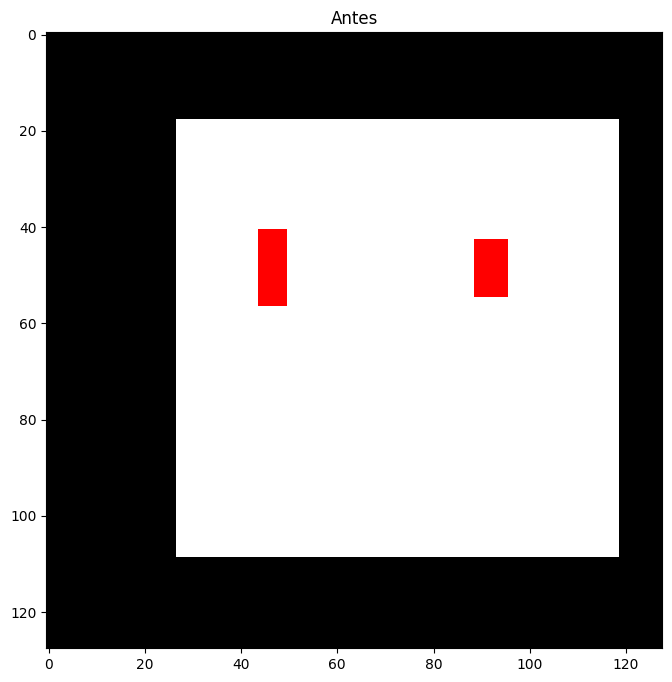

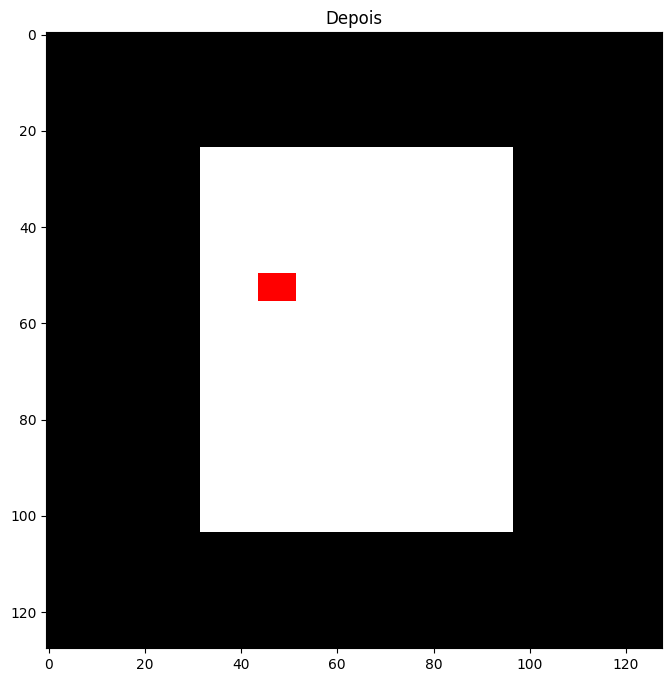

In [ ]:
random_index = np.random.randint(0, y_test_reduced.shape[0])

image = y_train_reduced[random_index]
image2= y_test_reduced[random_index]

plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.title(f'Antes')
plt.show()

plt.figure(figsize=(8, 8))
plt.imshow(image2)
plt.title(f'Depois')
plt.show()

In [ ]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

def processar_imagem(imagem_path, tamanho_alvo=(128, 128)):
    # Lê a imagem
    imagem = cv2.imread(imagem_path)

    # Converte para escala de cinza
    gray = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)

    # Binariza a imagem
    _, binary = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

    # Encontra os contornos
    contornos, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Pega o maior contorno (que deve ser o retângulo branco)
    contorno = max(contornos, key=cv2.contourArea)

    # Obtém o retângulo delimitador
    x, y, w, h = cv2.boundingRect(contorno)

    # Recorta a região de interesse
    roi = imagem[y:y+h, x:x+w]

    # Redimensiona para o tamanho alvo
    roi_redimensionada = cv2.resize(roi, tamanho_alvo)

    return roi_redimensionada

# Divide os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print("Formas dos dados:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

In [ ]:
import numpy as np
import cv2

def extract_bounding_boxes(images):
    bounding_boxes = []

    for img in images:
        # Converte para uint8 se necessário
        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8)

        # Converte para escala de cinza se for colorida
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Binariza a imagem (assume que o fundo é preto e o objeto é branco)
        _, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

        # Encontra os contornos na imagem
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Verifica se há contornos
        if contours:
            # Pega o maior contorno (assumindo que é o boi)
            largest_contour = max(contours, key=cv2.contourArea)

            # Obtém o retângulo delimitador
            x, y, w, h = cv2.boundingRect(largest_contour)

            # Normaliza as coordenadas
            height, width = img.shape
            x_norm = x / width
            y_norm = y / height
            w_norm = w / width
            h_norm = h / height

            bounding_boxes.append([x_norm, y_norm, w_norm, h_norm])
        else:
            # Se não houver contornos, adiciona uma bounding box vazia
            bounding_boxes.append([0, 0, 0, 0])

    return np.array(bounding_boxes)

# Processamento dos conjuntos de dados
y_train_bboxes = extract_bounding_boxes(y_train_reduced)
y_test_bboxes = extract_bounding_boxes(y_test_reduced)

print("Shapes dos conjuntos de dados:")
print(f"X_train_processed: {X_train_processed.shape}")
print(f"X_test_processed: {X_test_processed.shape}")
print(f"y_train_bboxes: {y_train_bboxes.shape}")
print(f"y_test_bboxes: {y_test_bboxes.shape}")

# Exemplo de uma bounding box
print("\nExemplo de uma bounding box normalizada:")
print(y_train_bboxes[0])

Shapes dos conjuntos de dados:
X_train_processed: (9570, 128, 128, 3)
X_test_processed: (798, 128, 128, 3)
y_train_bboxes: (9570, 4)
y_test_bboxes: (798, 4)

Exemplo de uma bounding box normalizada:
[0.1640625 0.046875  0.453125  0.6484375]


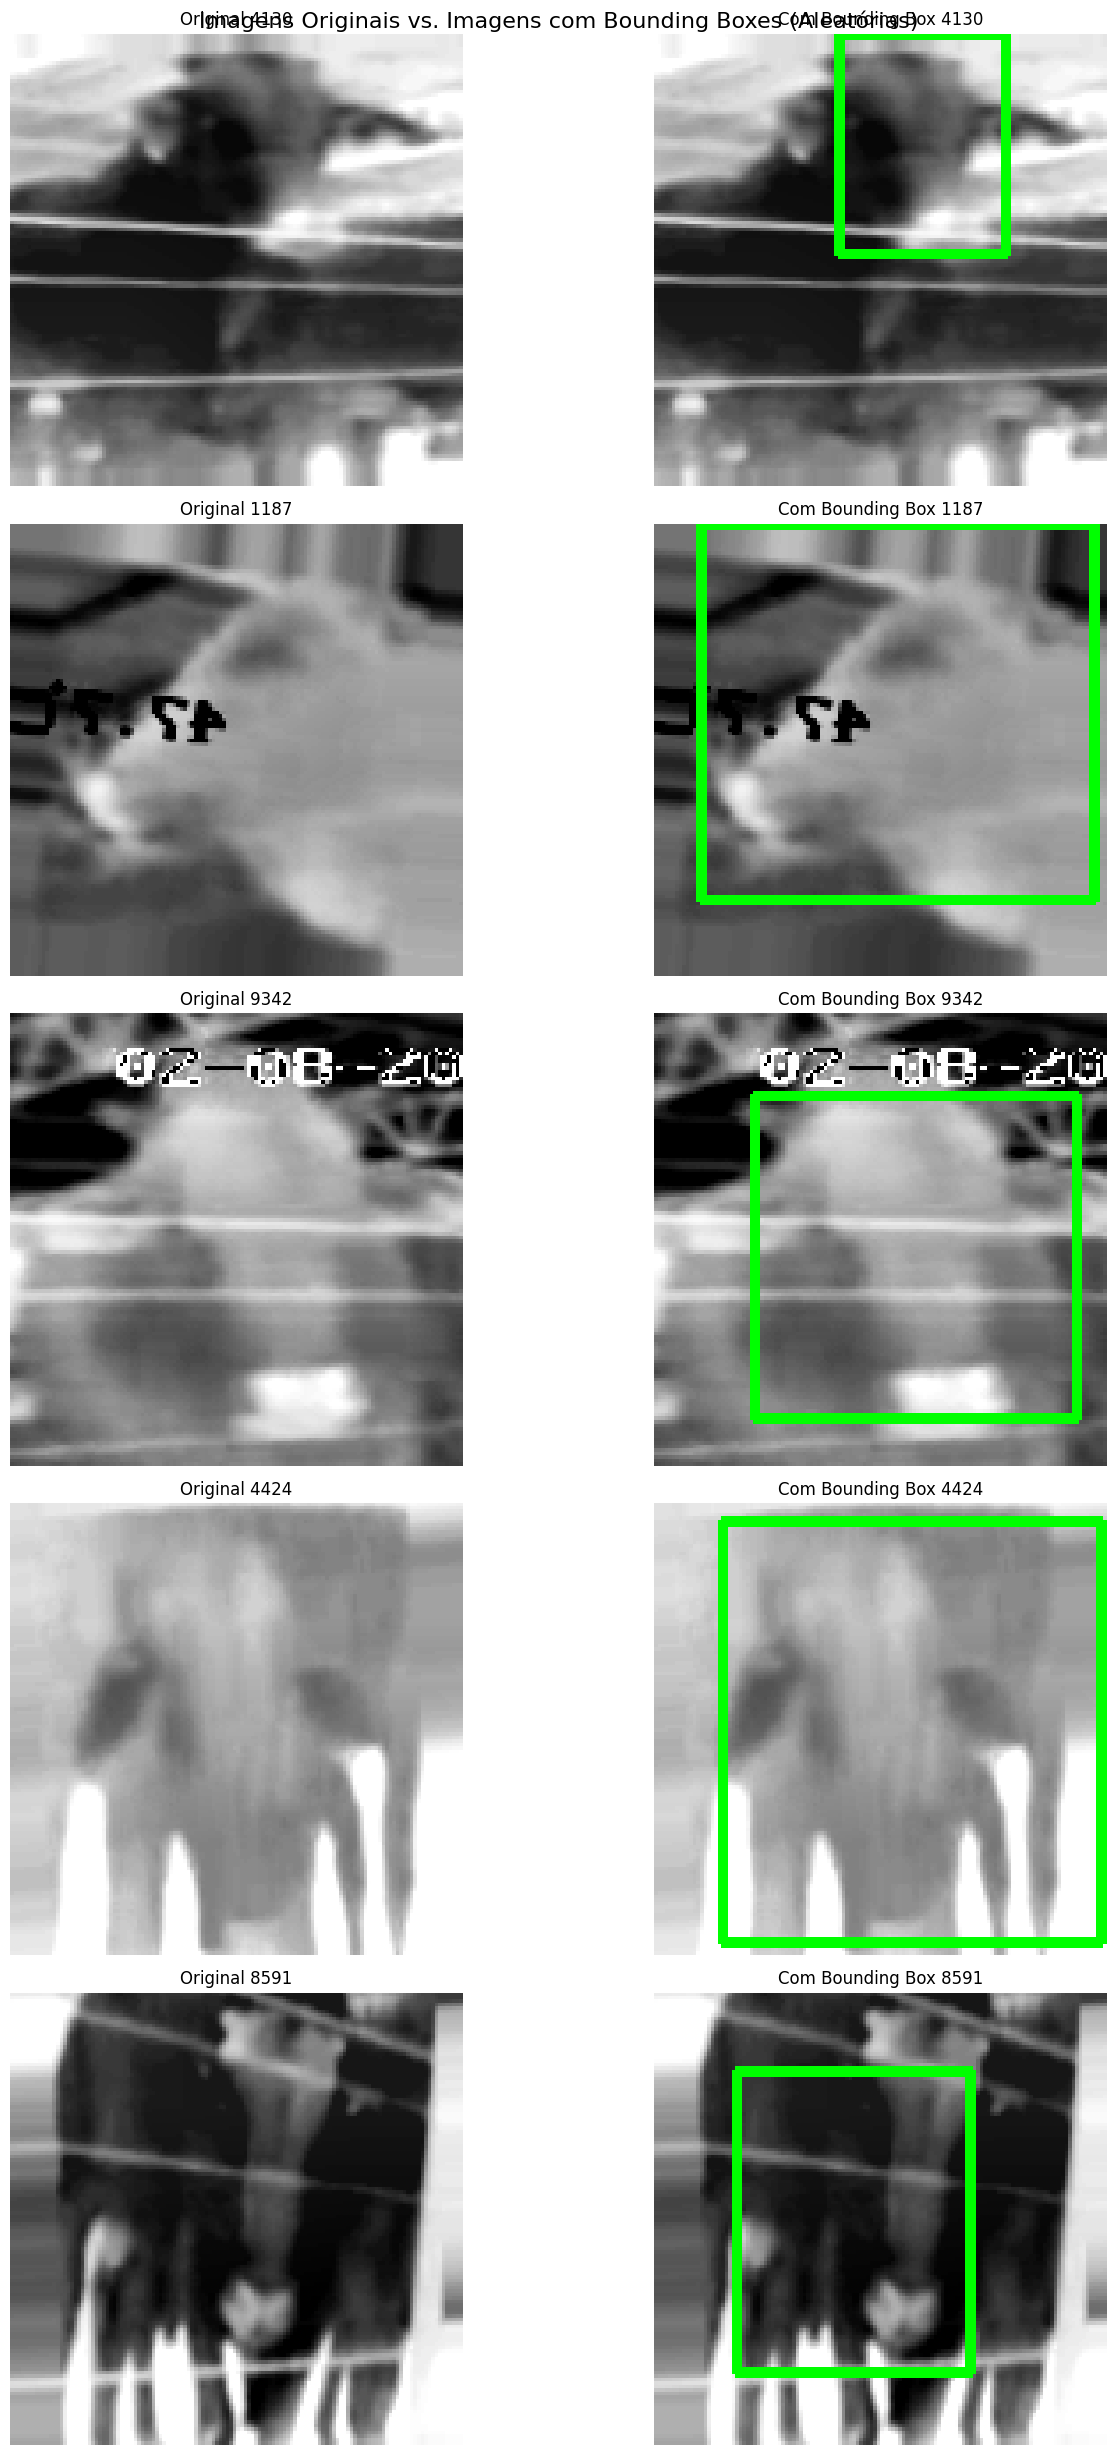

Shapes dos conjuntos de dados:
X_train_processed: (9570, 128, 128, 3)
y_train_bboxes: (9570, 4)

Exemplo de uma bounding box normalizada:
[0.40625   0.        0.3671875 0.484375 ]


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random

def draw_bounding_box(img, bbox):
    h, w = img.shape[:2]
    x, y, bw, bh = bbox
    x1, y1 = int(x * w), int(y * h)
    x2, y2 = int((x + bw) * w), int((y + bh) * h)
    return cv2.rectangle(img.copy(), (x1, y1), (x2, y2), (0, 255, 0), 2)

# Seleciona 5 índices aleatórios
random_indices = random.sample(range(len(X_train_processed)), 5)

fig, axs = plt.subplots(5, 2, figsize=(15, 25))
fig.suptitle('Imagens Originais vs. Imagens com Bounding Boxes (Aleatórias)', fontsize=16)

for i, idx in enumerate(random_indices):
    # Imagem original
    orig_img = X_train_processed[idx]
    if orig_img.shape[-1] == 1:  # Se for grayscale
        orig_img = np.squeeze(orig_img)

    axs[i, 0].imshow(orig_img, cmap='gray' if len(orig_img.shape) == 2 else None)
    axs[i, 0].set_title(f'Original {idx}')
    axs[i, 0].axis('off')

    # Imagem com bounding box
    bbox_img = draw_bounding_box(orig_img, y_train_bboxes[idx])
    axs[i, 1].imshow(bbox_img, cmap='gray' if len(bbox_img.shape) == 2 else None)
    axs[i, 1].set_title(f'Com Bounding Box {idx}')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

print("Shapes dos conjuntos de dados:")
print(f"X_train_processed: {X_train_processed.shape}")
print(f"y_train_bboxes: {y_train_bboxes.shape}")

# Exemplo de uma bounding box
print("\nExemplo de uma bounding box normalizada:")
print(y_train_bboxes[random_indices[0]])

In [ ]:
y_train_bboxes

array([[0.1640625, 0.046875 , 0.453125 , 0.6484375],
       [0.375    , 0.       , 0.4921875, 0.6796875],
       [0.078125 , 0.109375 , 0.5625   , 0.5625   ],
       ...,
       [0.015625 , 0.25     , 0.5546875, 0.671875 ],
       [0.       , 0.234375 , 0.6171875, 0.609375 ],
       [0.3828125, 0.25     , 0.6171875, 0.609375 ]])

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping

def iou_loss(y_true, y_pred):
    # Extraindo as coordenadas das bounding boxes
    y_true_x, y_true_y, y_true_w, y_true_h = tf.split(y_true, 4, axis=-1)
    y_pred_x, y_pred_y, y_pred_w, y_pred_h = tf.split(y_pred, 4, axis=-1)

    # Calculando as coordenadas das bordas das bounding boxes
    y_true_x1 = y_true_x - y_true_w / 2
    y_true_y1 = y_true_y - y_true_h / 2
    y_true_x2 = y_true_x + y_true_w / 2
    y_true_y2 = y_true_y + y_true_h / 2

    y_pred_x1 = y_pred_x - y_pred_w / 2
    y_pred_y1 = y_pred_y - y_pred_h / 2
    y_pred_x2 = y_pred_x + y_pred_w / 2
    y_pred_y2 = y_pred_y + y_pred_h / 2

    # Calculando a área de interseção
    inter_x1 = tf.maximum(y_true_x1, y_pred_x1)
    inter_y1 = tf.maximum(y_true_y1, y_pred_y1)
    inter_x2 = tf.minimum(y_true_x2, y_pred_x2)
    inter_y2 = tf.minimum(y_true_y2, y_pred_y2)

    inter_area = tf.maximum(inter_x2 - inter_x1, 0) * tf.maximum(inter_y2 - inter_y1, 0)

    # Calculando a área das bounding boxes
    true_area = (y_true_x2 - y_true_x1) * (y_true_y2 - y_true_y1)
    pred_area = (y_pred_x2 - y_pred_x1) * (y_pred_y2 - y_pred_y1)

    # Calculando a união
    union_area = true_area + pred_area - inter_area

    # Calculando o IoU
    iou = inter_area / (union_area + tf.keras.backend.epsilon())

    # Retornando o loss (1 - IoU)
    return 1 - iou

def create_model():
    inputs = layers.Input(shape=(128, 128, 3))

    x = layers.GaussianNoise(0.05)(inputs)

    # Regularização L2
    l2_reg = regularizers.l2(0.01)

    x = layers.Conv2D(4, (3, 3), kernel_initializer='he_normal', activation=LeakyReLU(alpha=0.01), padding='same')(inputs)
    x = layers.MaxPooling2D(pool_size=(4, 4))(x)  # Reduz 128x128 para 32x32

    x = layers.Conv2D(8, (3, 3), kernel_initializer='he_normal', activation=LeakyReLU(alpha=0.01), padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)  # Reduz 128x128 para 32x32

    x = layers.Conv2D(16, (3, 3), kernel_initializer='he_normal', activation=LeakyReLU(alpha=0.01), padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)  # Reduz 128x128 para 32x32

    x = layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', activation=LeakyReLU(alpha=0.01), padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)  # Reduz 128x128 para 32x32

    # Flatten para transformar as saídas convolucionais em vetores
    x = layers.Flatten()(x)

    x = layers.Dropout(0.1)(x)

    # Camada densa
    x = layers.Dense(10, activation=LeakyReLU(alpha=0.01), kernel_regularizer=l2_reg)(x)

    # Camada de saída com 4 neurônios (x, y, largura, altura da bounding box)
    outputs = layers.Dense(4, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Criando o modelo
model = create_model()

# Compilando o modelo com a nova função de loss
model.compile(optimizer='adam', loss=iou_loss, metrics=['mse', 'mae'])

# Resumo do modelo
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Treinando o modelo com EarlyStopping
# Certifique-se de que X_train_processed e y_train_bboxes estejam definidos
history = model.fit(X_train_processed, y_train_bboxes, epochs=300, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Model: "model_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_39 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_132 (Conv2D)         (None, 128, 128, 4)       112       
                                                                 
 max_pooling2d_130 (MaxPool  (None, 32, 32, 4)         0         
 ing2D)                                                          
                                                                 
 conv2d_133 (Conv2D)         (None, 32, 32, 16)        592       
                                                                 
 max_pooling2d_131 (MaxPool  (None, 16, 16, 16)        0         
 ing2D)                                                          
                                                                 
 conv2d_134 (Conv2D)         (None, 16, 16, 8)         116

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping

def iou_loss(y_true, y_pred):
    # Extraindo as coordenadas das bounding boxes
    y_true_x, y_true_y, y_true_w, y_true_h = tf.split(y_true, 4, axis=-1)
    y_pred_x, y_pred_y, y_pred_w, y_pred_h = tf.split(y_pred, 4, axis=-1)

    # Calculando as coordenadas das bordas das bounding boxes
    y_true_x1 = y_true_x - y_true_w / 2
    y_true_y1 = y_true_y - y_true_h / 2
    y_true_x2 = y_true_x + y_true_w / 2
    y_true_y2 = y_true_y + y_true_h / 2

    y_pred_x1 = y_pred_x - y_pred_w / 2
    y_pred_y1 = y_pred_y - y_pred_h / 2
    y_pred_x2 = y_pred_x + y_pred_w / 2
    y_pred_y2 = y_pred_y + y_pred_h / 2

    # Calculando a área de interseção
    inter_x1 = tf.maximum(y_true_x1, y_pred_x1)
    inter_y1 = tf.maximum(y_true_y1, y_pred_y1)
    inter_x2 = tf.minimum(y_true_x2, y_pred_x2)
    inter_y2 = tf.minimum(y_true_y2, y_pred_y2)

    inter_area = tf.maximum(inter_x2 - inter_x1, 0) * tf.maximum(inter_y2 - inter_y1, 0)

    # Calculando a área das bounding boxes
    true_area = (y_true_x2 - y_true_x1) * (y_true_y2 - y_true_y1)
    pred_area = (y_pred_x2 - y_pred_x1) * (y_pred_y2 - y_pred_y1)

    # Calculando a união
    union_area = true_area + pred_area - inter_area

    # Calculando o IoU
    iou = inter_area / (union_area + tf.keras.backend.epsilon())

    # Retornando o loss (1 - IoU)
    return 1 - iou

def create_model():
    inputs = layers.Input(shape=(128, 128, 3))

    x = layers.GaussianNoise(0.05)(inputs)

    # Regularização L2
    l2_reg = regularizers.l2(0.01)

    x = layers.Conv2D(4, (3, 3), kernel_initializer='he_normal', activation=LeakyReLU(alpha=0.01), padding='same')(inputs)
    x = layers.MaxPooling2D(pool_size=(4, 4))(x)  # Reduz 128x128 para 32x32

    x = layers.Conv2D(8, (3, 3), kernel_initializer='he_normal', activation=LeakyReLU(alpha=0.01), padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)  # Reduz 128x128 para 32x32

    x = layers.Conv2D(16, (3, 3), kernel_initializer='he_normal', activation=LeakyReLU(alpha=0.01), padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)  # Reduz 128x128 para 32x32

    x = layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', activation=LeakyReLU(alpha=0.01), padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)  # Reduz 128x128 para 32x32

    # Flatten para transformar as saídas convolucionais em vetores
    x = layers.Flatten()(x)

    x = layers.Dropout(0.1)(x)

    # Camada densa
    x = layers.Dense(10, activation=LeakyReLU(alpha=0.01), kernel_regularizer=l2_reg)(x)

    # Camada de saída com 4 neurônios (x, y, largura, altura da bounding box)
    outputs = layers.Dense(4, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Criando o modelo
model = create_model()

# Compilando o modelo com a nova função de loss
model.compile(optimizer='adam', loss=iou_loss, metrics=['mse', 'mae'])

# Resumo do modelo
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Treinando o modelo com EarlyStopping
# Certifique-se de que X_train_processed e y_train_bboxes estejam definidos
history = model.fit(X_train_processed, y_train_bboxes, epochs=300, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Model: "model_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_42 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_143 (Conv2D)         (None, 128, 128, 4)       112       
                                                                 
 max_pooling2d_141 (MaxPool  (None, 32, 32, 4)         0         
 ing2D)                                                          
                                                                 
 conv2d_144 (Conv2D)         (None, 32, 32, 8)         296       
                                                                 
 max_pooling2d_142 (MaxPool  (None, 16, 16, 8)         0         
 ing2D)                                                          
                                                                 
 conv2d_145 (Conv2D)         (None, 16, 16, 16)        116

In [ ]:
# Salvando o modelo treinado no formato .keras
model.save('pega_cabeca_11k.keras')

1/1 [==============================] - 0s 97ms/step


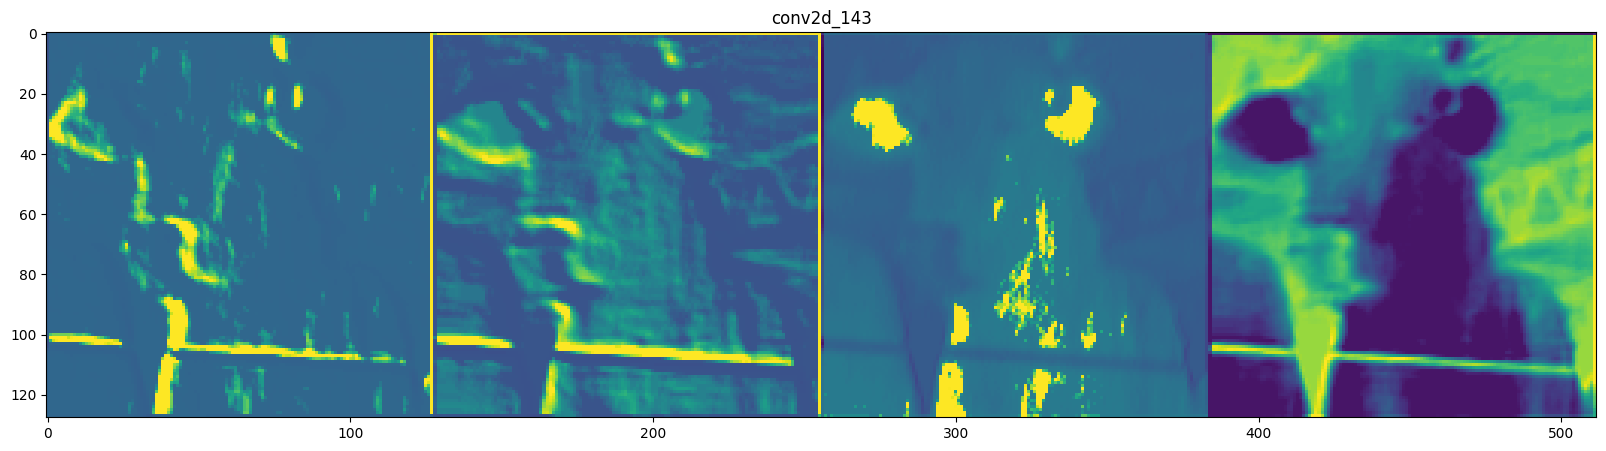

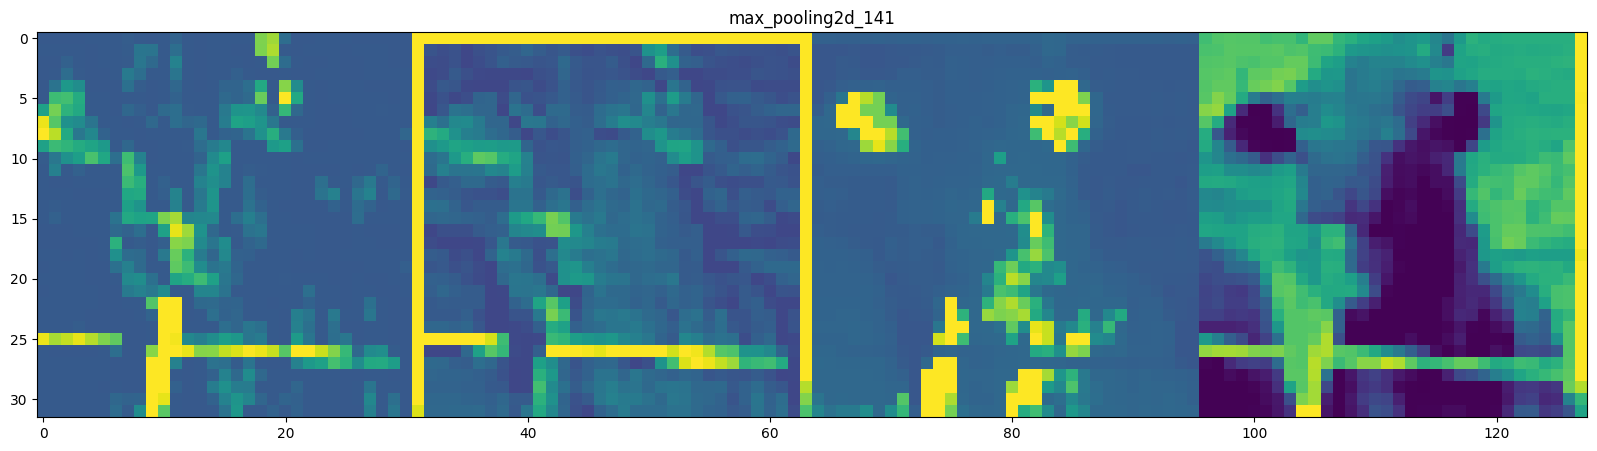

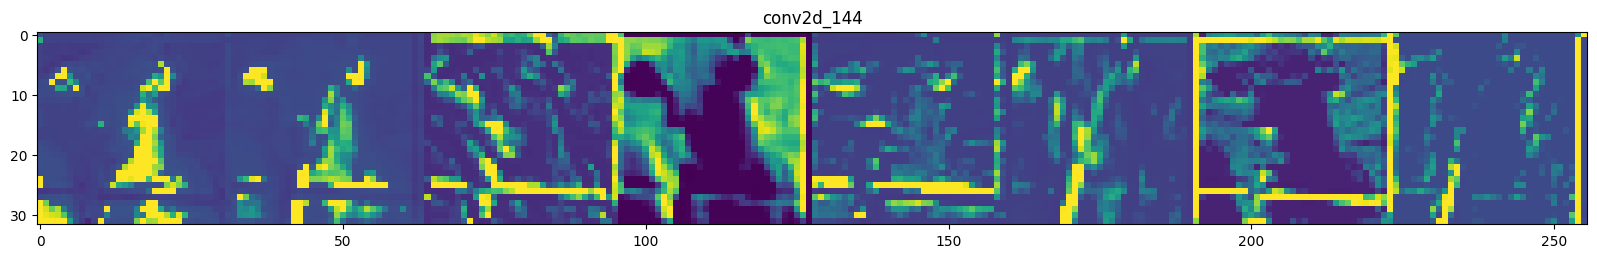

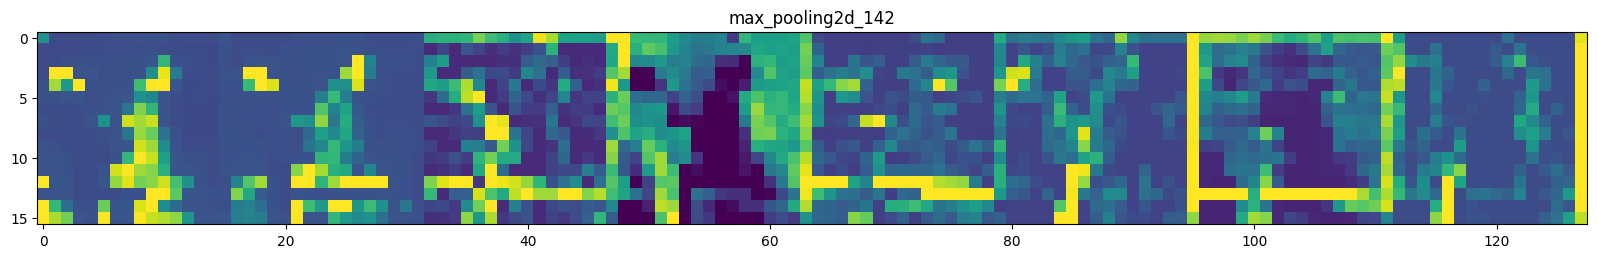

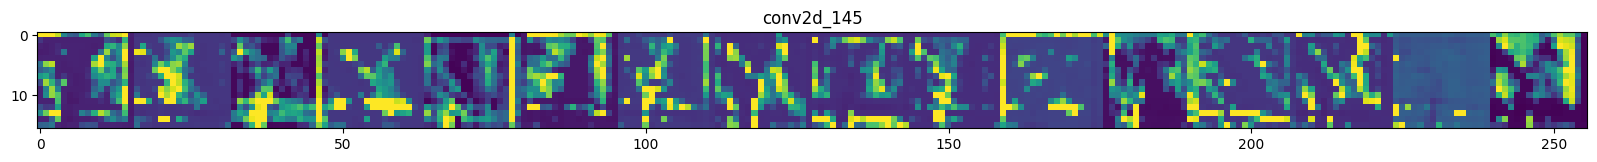

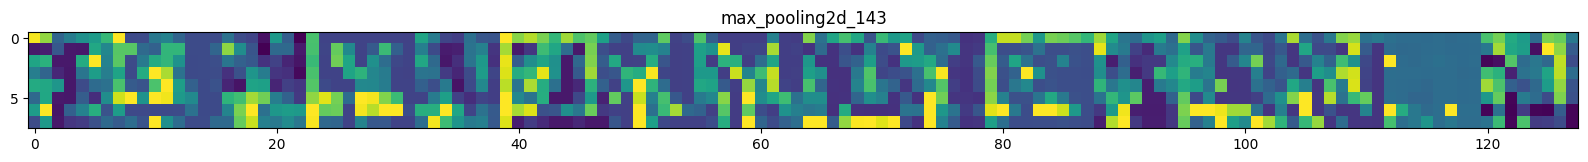

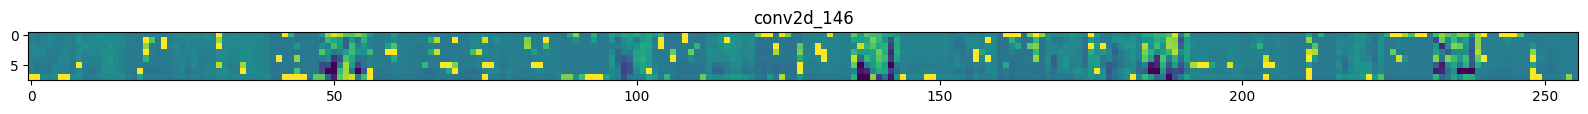

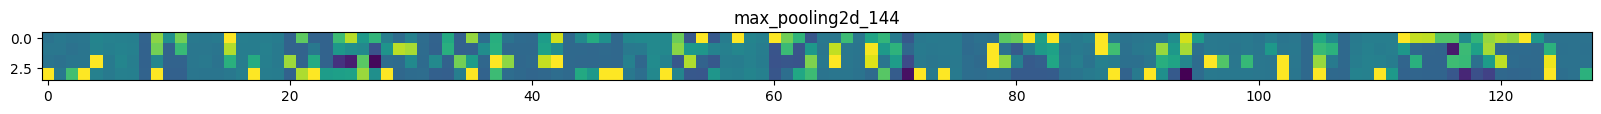

In [ ]:
saidas_seq = [layer.output for layer in model.layers[1:]]
visualizacao_model = tf.keras.models.Model(
    inputs=model.input, outputs=saidas_seq)

Indice_IMG_Teste = 1  # Indicar aqui a posição da imagem a ser avaliada

x = X_train_processed[0]
x = x.reshape((1,) + x.shape)

mapas_sequenciais = visualizacao_model.predict(x)
layer_nomes = [layer.name for layer in model.layers[1:]]

for layer_name, feature_map in zip(layer_nomes, mapas_sequenciais):
    if len(feature_map.shape) == 4:
        n_features = feature_map.shape[-1]
        size = feature_map.shape[1]
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')

            # Tile each filter into this big horizontal grid
            display_grid[:, i * size: (i + 1) * size] = x

        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

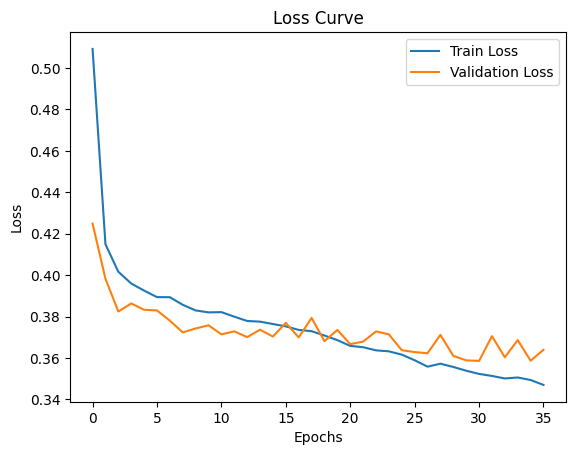

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
prediction = model.predict(X_test_processed)

25/25 [==============================] - 0s 3ms/step


In [ ]:
prediction[0]

array([0.35532284, 0.23544388, 0.35044795, 0.47844058], dtype=float32)

In [ ]:
y_test_bboxes[0]

array([0.375    , 0.296875 , 0.3203125, 0.4140625])

25/25 [==============================] - 0s 3ms/step


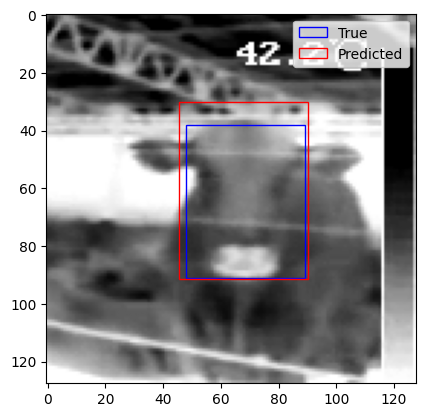

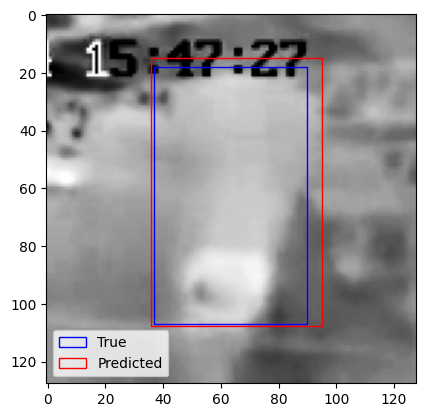

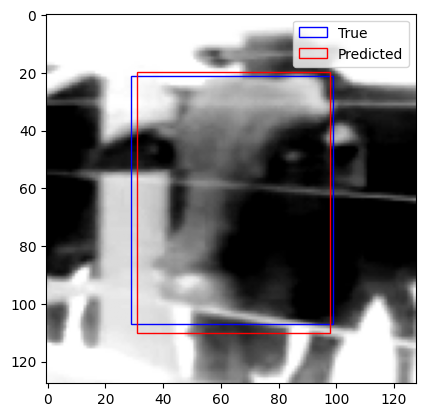

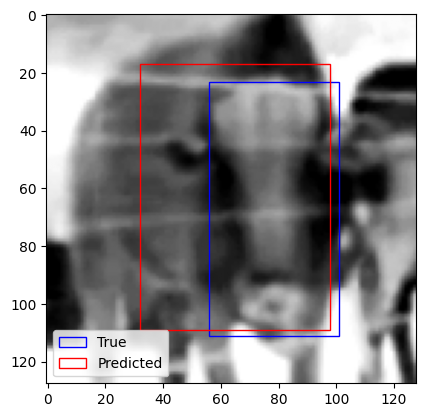

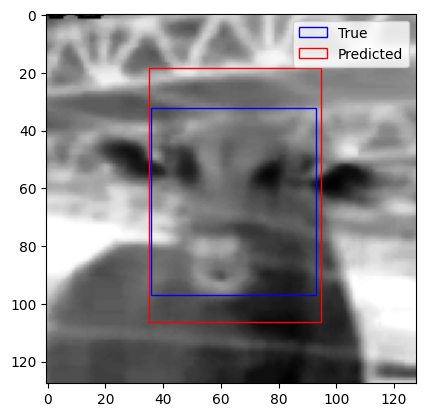

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Função para extrair as bounding boxes como no seu código
def extract_bounding_boxes(images):
    bounding_boxes = []

    for img in images:
        # Converte para uint8 se necessário
        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8)

        # Converte para escala de cinza se for colorida
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Binariza a imagem (assume que o fundo é preto e o objeto é branco)
        _, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

        # Encontra os contornos na imagem
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Verifica se há contornos
        if contours:
            # Pega o maior contorno (assumindo que é o objeto principal)
            largest_contour = max(contours, key=cv2.contourArea)

            # Obtém o retângulo delimitador
            x, y, w, h = cv2.boundingRect(largest_contour)

            # Normaliza as coordenadas
            height, width = img.shape
            x_norm = x / width
            y_norm = y / height
            w_norm = w / width
            h_norm = h / height

            bounding_boxes.append([x_norm, y_norm, w_norm, h_norm])
        else:
            # Se não houver contornos, adiciona uma bounding box vazia
            bounding_boxes.append([0, 0, 0, 0])

    return np.array(bounding_boxes)

# Processamento dos conjuntos de dados de treino e teste
y_train_bboxes = extract_bounding_boxes(y_train_reduced)
y_test_bboxes = extract_bounding_boxes(y_test_reduced)

# Exemplo de previsões com o modelo usando o conjunto de teste
y_pred_bboxes = model.predict(X_test_processed)

# Função para plotar as bounding boxes reais e previstas
def plot_bounding_boxes(image, true_bbox, pred_bbox):
    plt.imshow(image)

    # Desenhar a bounding box real (em azul)
    img_h, img_w = image.shape[:2]
    true_rect = plt.Rectangle((true_bbox[0] * img_w, true_bbox[1] * img_h),
                              true_bbox[2] * img_w, true_bbox[3] * img_h,
                              edgecolor='blue', facecolor='none', label='True')

    # Desenhar a bounding box prevista (em vermelho)
    pred_rect = plt.Rectangle((pred_bbox[0] * img_w, pred_bbox[1] * img_h),
                              pred_bbox[2] * img_w, pred_bbox[3] * img_h,
                              edgecolor='red', facecolor='none', label='Predicted')

    plt.gca().add_patch(true_rect)
    plt.gca().add_patch(pred_rect)
    plt.legend(handles=[true_rect, pred_rect])
    plt.show()

# Exemplo de comparação visual para uma imagem de teste
for i in range(5):  # Visualiza os primeiros 5 exemplos
    plot_bounding_boxes(X_test_processed[i], y_test_bboxes[i], y_pred_bboxes[i])